In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import xgboost as xgb
from xgboost import XGBRegressor


In [39]:
uber_data = pd.read_parquet("data/uber_data.parquet")
uber_data.head()

,passenger_name,driver_name,pickup_lat,pickup_lng,dropoff_lat,dropoff_lng,ride_distance,pickup_time,ride_duration,dropoff_time
0,Michael Hampton,Vincent Lopez,-83.7477475,114.626879,49.6809570,-14.982790,8.372402,2023-03-01 04:32:42+00:00,0 days 00:11:00,2023-03-01 04:43:42+00:00
1,Christopher Harris DVM,Mitchell Thomas,-51.4480075,174.613592,-78.4968455,137.061427,7.848521,2023-04-08 16:12:47+00:00,0 days 00:25:00,2023-04-08 16:37:47+00:00
2,Nicole Parker,Melissa Fox,-86.6937710,140.323530,-47.4600400,167.411274,2.408761,2023-02-11 12:35:58+00:00,0 days 00:41:00,2023-02-11 13:16:58+00:00
3,Manuel Rodriguez,Steven Lane,0.1201170,-137.280427,-74.7913090,41.510408,11.794800,2023-01-29 09:26:14+00:00,0 days 00:32:00,2023-01-29 09:58:14+00:00
4,Kaitlin Briggs,James Valentine,-0.6422705,-22.306202,81.6031915,67.481687,13.266921,2023-02-10 17:15:32+00:00,0 days 00:57:00,2023-02-10 18:12:32+00:00


# 1. Exploratory Data Analysis

In [40]:
uber_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   passenger_name  1000 non-null   object             
 1   driver_name     1000 non-null   object             
 2   pickup_lat      1000 non-null   object             
 3   pickup_lng      1000 non-null   object             
 4   dropoff_lat     1000 non-null   object             
 5   dropoff_lng     1000 non-null   object             
 6   ride_distance   1000 non-null   float64            
 7   pickup_time     1000 non-null   datetime64[ns, UTC]
 8   ride_duration   1000 non-null   timedelta64[ns]    
 9   dropoff_time    1000 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), float64(1), object(6), timedelta64[ns](1)
memory usage: 78.2+ KB


In [41]:
uber_data.describe()

,ride_distance,ride_duration
count,1000.000000,1000
mean,10.332054,0 days 00:32:43.860000
std,5.726193,0 days 00:15:57.031143176
min,0.510616,0 days 00:05:00
25%,5.447223,0 days 00:19:00
50%,10.136036,0 days 00:33:00
75%,15.377844,0 days 00:46:00
max,19.968133,0 days 01:00:00


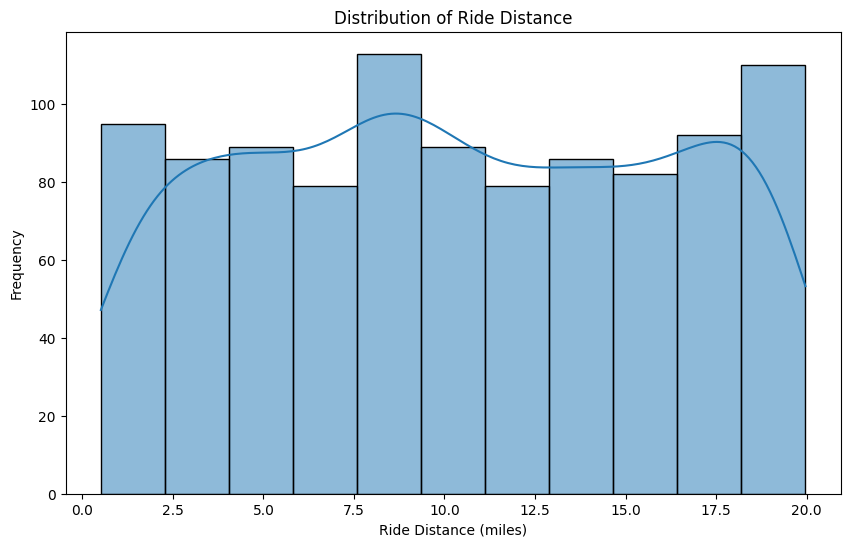

In [42]:
# Visualize the distribution of ride_distance
plt.figure(figsize=(10, 6))
sns.histplot(uber_data['ride_distance'], kde=True)
plt.title("Distribution of Ride Distance")
plt.xlabel("Ride Distance (miles)")
plt.ylabel("Frequency")
plt.show()

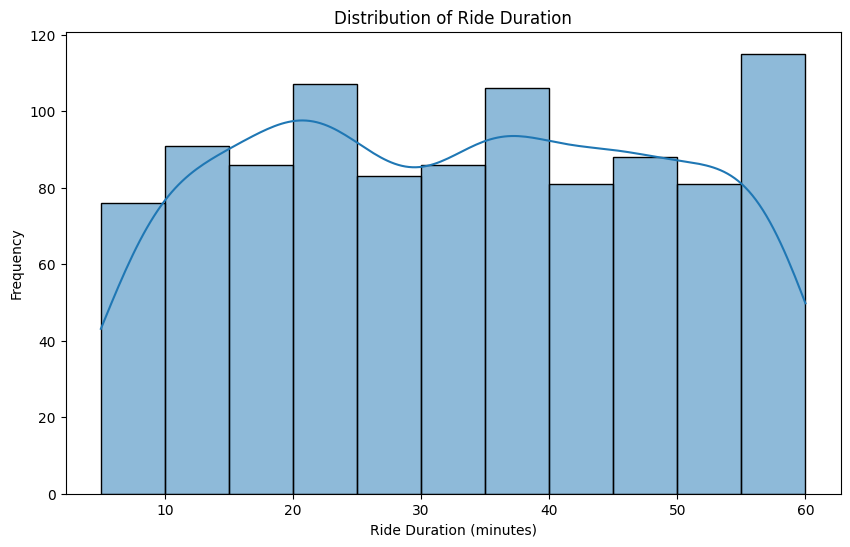

In [43]:
# Visualize the distribution of ride_duration
plt.figure(figsize=(10, 6))
sns.histplot(uber_data['ride_duration'].dt.total_seconds() / 60, kde=True)
plt.title("Distribution of Ride Duration")
plt.xlabel("Ride Duration (minutes)")
plt.ylabel("Frequency")
plt.show()

In [44]:
# Calculate correlation between ride_distance and ride_duration
correlation = uber_data['ride_distance'].corr(uber_data['ride_duration'].dt.total_seconds() / 60)
print("Correlation between Ride Distance and Ride Duration:", correlation)

Correlation between Ride Distance and Ride Duration: 0.057060978637404475


# 2. Feature Engineering

In [45]:
# Function to calculate the Haversine distance between two points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    return 2 * R * np.arcsin(np.sqrt(a))

# Convert latitude and longitude columns to float data type
uber_data['pickup_lat'] = uber_data['pickup_lat'].astype(float)
uber_data['pickup_lng'] = uber_data['pickup_lng'].astype(float)
uber_data['dropoff_lat'] = uber_data['dropoff_lat'].astype(float)
uber_data['dropoff_lng'] = uber_data['dropoff_lng'].astype(float)

# Time-based features
uber_data['pickup_day_of_week'] = uber_data['pickup_time'].dt.dayofweek
uber_data['pickup_hour'] = uber_data['pickup_time'].dt.hour
uber_data['dropoff_day_of_week'] = uber_data['dropoff_time'].dt.dayofweek
uber_data['dropoff_hour'] = uber_data['dropoff_time'].dt.hour

# Speed feature
uber_data['ride_speed'] = uber_data['ride_distance'] / (uber_data['ride_duration'].dt.total_seconds() / 3600)  # Speed in miles per hour

# Direct distance feature
uber_data['direct_distance'] = haversine(uber_data['pickup_lat'], uber_data['pickup_lng'], uber_data['dropoff_lat'], uber_data['dropoff_lng'])

uber_data.head()

,passenger_name,driver_name,pickup_lat,pickup_lng,dropoff_lat,dropoff_lng,ride_distance,pickup_time,ride_duration,dropoff_time,pickup_day_of_week,pickup_hour,dropoff_day_of_week,dropoff_hour,ride_speed,direct_distance
0,Michael Hampton,Vincent Lopez,-83.747748,114.626879,49.680957,-14.982790,8.372402,2023-03-01 04:32:42+00:00,0 days 00:11:00,2023-03-01 04:43:42+00:00,2,4,2,4,45.667649,15945.643609
1,Christopher Harris DVM,Mitchell Thomas,-51.448008,174.613592,-78.496846,137.061427,7.848521,2023-04-08 16:12:47+00:00,0 days 00:25:00,2023-04-08 16:37:47+00:00,5,16,5,16,18.836451,3350.574882
2,Nicole Parker,Melissa Fox,-86.693771,140.323530,-47.460040,167.411274,2.408761,2023-02-11 12:35:58+00:00,0 days 00:41:00,2023-02-11 13:16:58+00:00,5,12,5,13,3.525017,4405.498248
3,Manuel Rodriguez,Steven Lane,0.120117,-137.280427,-74.791309,41.510408,11.794800,2023-01-29 09:26:14+00:00,0 days 00:32:00,2023-01-29 09:58:14+00:00,6,9,6,9,22.115251,11711.643182
4,Kaitlin Briggs,James Valentine,-0.642270,-22.306202,81.603191,67.481687,13.266921,2023-02-10 17:15:32+00:00,0 days 00:57:00,2023-02-10 18:12:32+00:00,4,17,4,18,13.965180,10074.750885


# 3. Data Pre-Processing

In [46]:
# Check for missing values in the dataframe
missing_values = uber_data.isnull().sum()
print(missing_values)

passenger_name         0
driver_name            0
pickup_lat             0
pickup_lng             0
dropoff_lat            0
dropoff_lng            0
ride_distance          0
pickup_time            0
ride_duration          0
dropoff_time           0
pickup_day_of_week     0
pickup_hour            0
dropoff_day_of_week    0
dropoff_hour           0
ride_speed             0
direct_distance        0
dtype: int64


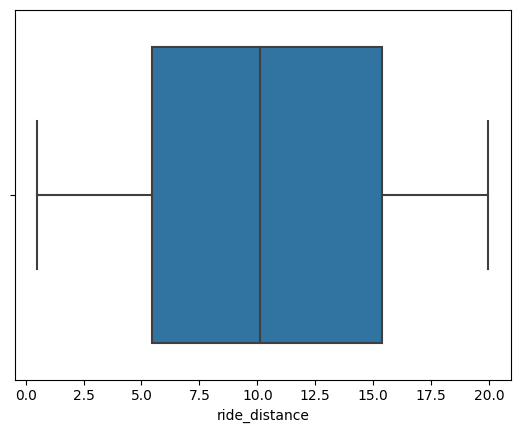

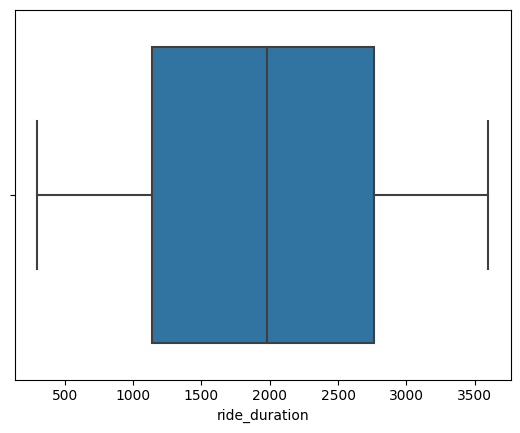

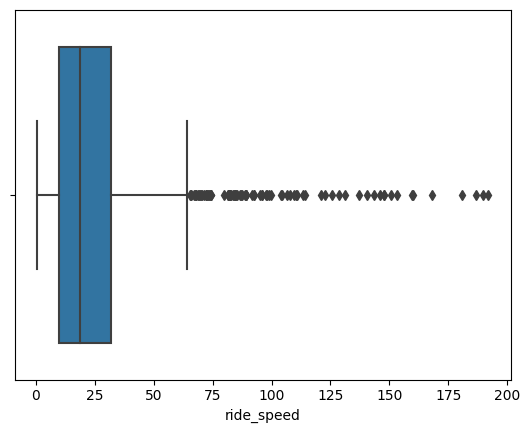

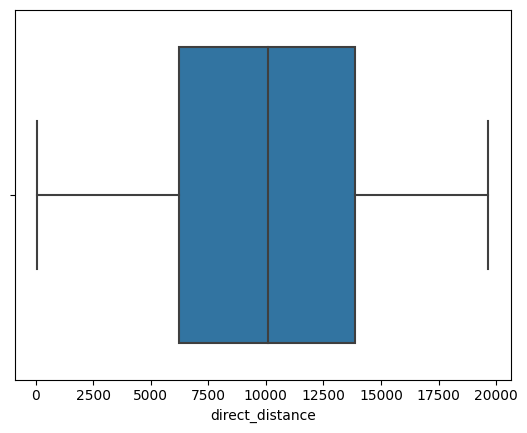

In [47]:
# Box plot for ride_distance
sns.boxplot(x=uber_data['ride_distance'])
plt.show()

# Box plot for ride_duration
sns.boxplot(x=uber_data['ride_duration'].dt.total_seconds())
plt.show()

# Box plot for ride_speed
sns.boxplot(x=uber_data['ride_speed'])
plt.show()

# Box plot for direct_distance
sns.boxplot(x=uber_data['direct_distance'])
plt.show()

In [50]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

def bearing(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    y = np.sin(lon2 - lon1) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lon2 - lon1)
    return np.degrees(np.arctan2(y, x))

uber_data['haversine_distance'] = haversine_distance(uber_data['pickup_lat'], uber_data['pickup_lng'], uber_data['dropoff_lat'], uber_data['dropoff_lng'])
uber_data['bearing'] = bearing(uber_data['pickup_lat'], uber_data['pickup_lng'], uber_data['dropoff_lat'], uber_data['dropoff_lng'])


In [54]:
uber_data.head()

,passenger_name,driver_name,pickup_lat,pickup_lng,dropoff_lat,dropoff_lng,ride_distance,pickup_time,ride_duration,dropoff_time,pickup_day_of_week,pickup_hour,dropoff_day_of_week,dropoff_hour,ride_speed,direct_distance,haversine_distance,bearing,ride_duration_minutes
0,Michael Hampton,Vincent Lopez,-83.747748,114.626879,49.680957,-14.982790,8.372402,2023-03-01 04:32:42+00:00,0 days 00:11:00,2023-03-01 04:43:42+00:00,2,2023-03-01 04:00:00+00:00,2,4,45.667649,15945.643609,15945.643609,-123.267202,11.0
1,Christopher Harris DVM,Mitchell Thomas,-51.448008,174.613592,-78.496846,137.061427,7.848521,2023-04-08 16:12:47+00:00,0 days 00:25:00,2023-04-08 16:37:47+00:00,5,2023-04-08 16:00:00+00:00,5,16,18.836451,3350.574882,3350.574882,-165.988305,25.0
2,Nicole Parker,Melissa Fox,-86.693771,140.323530,-47.460040,167.411274,2.408761,2023-02-11 12:35:58+00:00,0 days 00:41:00,2023-02-11 13:16:58+00:00,5,2023-02-11 12:00:00+00:00,5,13,3.525017,4405.498248,4405.498248,28.867569,41.0
3,Manuel Rodriguez,Steven Lane,0.120117,-137.280427,-74.791309,41.510408,11.794800,2023-01-29 09:26:14+00:00,0 days 00:32:00,2023-01-29 09:58:14+00:00,6,2023-01-29 09:00:00+00:00,6,9,22.115251,11711.643182,11711.643182,179.671120,32.0
4,Kaitlin Briggs,James Valentine,-0.642270,-22.306202,81.603191,67.481687,13.266921,2023-02-10 17:15:32+00:00,0 days 00:57:00,2023-02-10 18:12:32+00:00,4,2023-02-10 17:00:00+00:00,4,18,13.965180,10074.750885,10074.750885,8.397221,57.0


# 4. Model Select

In [64]:
# Aggregate the data by pickup hour and create target variable (ride count)
uber_data['pickup_hour'] = uber_data['pickup_time'].dt.floor('H')
ride_counts = uber_data.groupby('pickup_hour').size().reset_index(name='ride_count')

# Create additional time-based features
ride_counts['hour_of_day'] = ride_counts['pickup_hour'].dt.hour
ride_counts['day_of_week'] = ride_counts['pickup_hour'].dt.dayofweek
ride_counts['is_weekend'] = ride_counts['day_of_week'].isin([5, 6]).astype(int)

uber_data['ride_duration_minutes'] = uber_data['ride_duration'].dt.total_seconds() / 60
avg_ride_duration = uber_data.groupby('pickup_hour')['ride_duration_minutes'].mean().reset_index(name='avg_ride_duration')
ride_counts = ride_counts.merge(avg_ride_duration, on='pickup_hour', how='left')

avg_ride_distance = uber_data.groupby('pickup_hour')['ride_distance'].mean().reset_index(name='avg_ride_distance')
ride_counts = ride_counts.merge(avg_ride_distance, on='pickup_hour', how='left')

avg_haversine_distance = uber_data.groupby('pickup_hour')['haversine_distance'].mean().reset_index(name='avg_haversine_distance')
ride_counts = ride_counts.merge(avg_haversine_distance, on='pickup_hour', how='left')

avg_bearing = uber_data.groupby('pickup_hour')['bearing'].mean().reset_index(name='avg_bearing')
ride_counts = ride_counts.merge(avg_bearing, on='pickup_hour', how='left')

unique_drivers = uber_data.groupby('pickup_hour')['driver_name'].nunique().reset_index(name='unique_drivers')
ride_counts = ride_counts.merge(unique_drivers, on='pickup_hour', how='left')


# Split the data into train and test sets
X = ride_counts[['hour_of_day', 'day_of_week', 'is_weekend', 'avg_ride_duration', 'avg_ride_distance', 'avg_haversine_distance','avg_bearing', 'unique_drivers']]
y = ride_counts['ride_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

lr_mae = mean_absolute_error(y_test, lr_preds)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_r2 = r2_score(y_test, lr_preds)
print("Linear Regression: R2 Score:", lr_r2)
print("Linear Regression: Mean Absolute Error:", lr_mae)
print("Linear Regression: Root Mean Squared Error:", lr_rmse)

# Train and evaluate the XGBoost Regressor model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_r2 = r2_score(y_test, xgb_preds)
print("XGBoost Regressor: R2 Score:", xgb_r2)
print("XGBoost Regressor: Mean Absolute Error:", xgb_mae)
print("XGBoost Regressor: Root Mean Squared Error:", xgb_rmse)


Linear Regression: R2 Score: 1.0
Linear Regression: Mean Absolute Error: 5.081143413315134e-16
Linear Regression: Root Mean Squared Error: 6.430291790353852e-16
XGBoost Regressor: R2 Score: 0.9999999867639319
XGBoost Regressor: Mean Absolute Error: 2.3163900784919598e-05
XGBoost Regressor: Root Mean Squared Error: 5.8168884012648405e-05


# 5. Conclusion

**Exploratory Data Analysis (EDA):** The initial step involved exploring the dataset and understanding its structure, relationships between variables, and any potential issues or anomalies. This stage allowed for the identification of relevant features and informed the subsequent feature engineering steps.

**Feature Engineering**: Based on the EDA, new features were created to improve the model's predictive power. These included time-based features like hour of day, day of the week, and whether the day is a weekend or not. Additional features like unique drivers, haversine distance, and ride duration were also considered to enhance the model's performance.

**Data Pre-processing**: The data was cleaned and pre-processed, which involved handling missing values, converting data types, and aggregating information as needed.

**Model Selection**: Linear Regression and XGBoost Regressor models were chosen and trained on the dataset. Their performance was compared using metrics like R2 score, Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE).

**Overfitting Concerns**: The models showed exceptionally high R2 scores, which can indicate overfitting. Overfitting occurs when a model performs very well on the training data but poorly on unseen data, indicating that it has learned the noise in the dataset rather than the underlying patterns. In such cases, the model is unlikely to generalize well to new data.